# Clasificación de imágenes de Radar de Apertura Sintética aplicando CORINE Land Cover adaptada para Colombia mediante Redes Neuronales Convolucionales.
 Versión Final: Datos 32 bit, google colab.




In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# -*- coding: utf-8 -*-

# Librerías propias para las redes neuronales por convolución
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras import layers
from keras.models import Model
# model architectures

#so
import os
import pathlib

#libreria para el modelo resnet50 
from keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from keras.preprocessing import image


# Libreria para arreglos multidimensionales
import numpy as np

import json
import pickle
# Librería para graficar 
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import itertools
from keras.utils.vis_utils import plot_model

import PIL
import PIL.Image
import os

# Librerías para obtener métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Universidad/tesis/classification/model_v3
%ls

/gdrive/MyDrive/Universidad/tesis/classification/model_v3
histories/  images.zip            models/       resultados/
images/     modeling_colab.ipynb  __pycache__/  tif2np.py


## Prepare data

In [ ]:
# from zipfile import ZipFile
# with ZipFile('images.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [ ]:
# from tif2np import prepare_tif

In [ ]:
# prepare_tif('./images/32_bit_tif/train/',output='./images/32_bit_tif/train',img_height=200,img_widht=200)
# prepare_tif('./images/32_bit_tif/val/',output='./images/32_bit_tif/val',img_height=200,img_widht=200)
# prepare_tif('./images/32_bit_tif/test/',output='./images/32_bit_tif/test',img_height=200,img_widht=200)

['11', '21', '22', '23', '24', '31', '32', '33', '52']
Founded 3349 images from 9 classes
['11', '21', '22', '23', '24', '31', '32', '33', '52']
Founded 1113 images from 9 classes
['11', '21', '22', '23', '24', '31', '32', '33', '52']
Founded 1124 images from 9 classes


In [ ]:
train_data = np.load('./images/32_bit_tif/train.npz')
val_data = np.load('./images/32_bit_tif/val.npz')
test_data = np.load('./images/32_bit_tif/test.npz')

X = train_data['x']
y = train_data['y']

X_val = val_data['x']
y_val = val_data['y']

X_test = test_data['x']
y_test = test_data['y']

batch_size =32
num_classes = 9

step_size_train = len(X)/batch_size
step_size_val = len(X_val)/batch_size
step_size_test = len(X_test)/batch_size

## Modelos

### Modelo 1

In [ ]:
#Creación Modelo
#Design
# Se define como un modelo secuencial

model = Sequential()

# Se añaden las capas y sus hiperparámetros
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
#model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
# La capa de salida debe tener el mismo número de clases
model.add(Dense(num_classes, activation='softmax'))
#Compilation
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

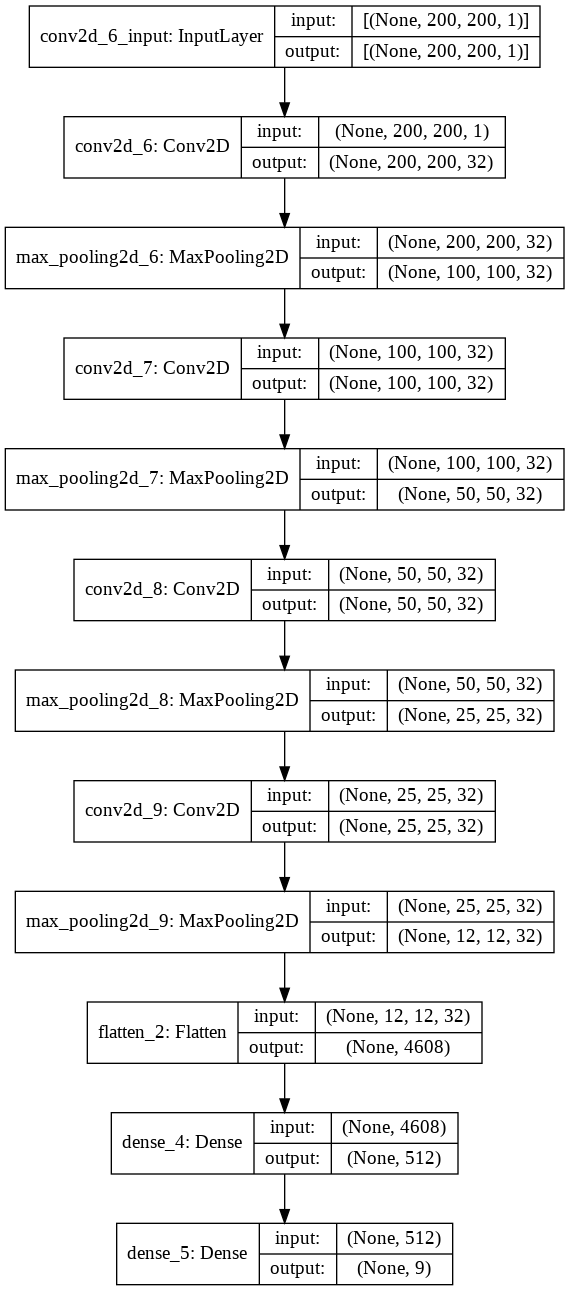

In [ ]:
dot_img_file = './models/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
#se me olvido guardarle los callback
#callbacks
callbacks_m1 = [ModelCheckpoint(filepath="./models/model_1.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_m1 = model.fit(X,y,
                   steps_per_epoch = step_size_train,
                   validation_data = (X_val,y_val),
                   validation_steps = step_size_val,
                   epochs=50,callbacks=callbacks_m1)

In [ ]:
with open('./histories/model_1', 'wb') as file_pi:
        pickle.dump(history_m1.history, file_pi)
model.save('./models/model_1')

INFO:tensorflow:Assets written to: ./models/model_1/assets


In [ ]:
%ls models/model_1

assets/  saved_model.pb  variables/


In [ ]:
#https://www.tensorflow.org/tutorials/keras/save_and_load
model = tf.keras.models.load_model('models/model_1')

# Check its architecture
# model.summary()

In [ ]:
history_m1 = pickle.load(open('./histories/model_1', "rb"))

In [ ]:
eval_1 = model.evaluate(X_test, y_test, verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
eval_1
# print(model.predict(test_images).shape)

37/37 - 8s - loss: 5.4180 - accuracy: 0.5397


[5.4180145263671875, 0.5397236347198486]

In [ ]:
results_train = model.evaluate(X, y, verbose=2)
results_val = model.evaluate(X_val, y_val, verbose=2)
results_test = model.evaluate(X_test, y_test, verbose=2)
results_train,results_val,results_test

108/108 - 24s - loss: 0.0018 - accuracy: 0.9997
36/36 - 8s - loss: 5.1175 - accuracy: 0.5344
37/37 - 8s - loss: 5.4180 - accuracy: 0.5397


([0.0018290482694283128, 0.9997101426124573],
 [5.117522239685059, 0.5343776941299438],
 [5.4180145263671875, 0.5397236347198486])

In [ ]:
model_1 = tf.keras.models.load_model('./models/model_1')
results_train_1 = model_1.evaluate(X, y, verbose=2)
results_val_1 = model_1.evaluate(X_val, y_val, verbose=2)
results_test_1 = model_1.evaluate(X_test, y_test, verbose=2)

model_1_2 = tf.keras.models.load_model('./models/model_1.h5')
results_train_1_2 = model_1_2.evaluate(X, y, verbose=2)
results_val_1_2 = model_1_2.evaluate(X_val, y_val, verbose=2)
results_test_1_2 = model_1_2.evaluate(X_test, y_test, verbose=2)

results_train_1,results_val_1,results_test_1, results_train_1_2,results_val_1_2,results_test_1_2
models_res = []

models_res.append({"Modelo":"15",
                   "type":"full",
                  "Descripción":"Conv Net",
                      "train":{
                          "loss":str(results_train_1[0]),
                          "acc":str(results_train_1[1])
                      },
                      "val":{
                          "loss":str(results_val_1[0]),
                          "acc":str(results_val_1[1]),
                      },
                      "test":{
                          "loss":str(results_test_1[0]),
                          "acc":str(results_test_1[1]),
                      },

                 })
models_res.append({"Modelo":"15",
                   "type":"callback",
                  "Descripción":"Conv Net",
                      "train":{
                          "loss":str(results_train_1_2[0]),
                          "acc":str(results_train_1_2[1]),

                      },
                      "val":{
                          "loss":str(results_val_1_2[0]),
                          "acc":str(results_val_1_2[1]),
                      },
                      "test":{
                          "loss":str(results_test_1_2[0]),
                          "acc":str(results_test_1_2[1]),
                      },

                 })
models_res

108/108 - 25s - loss: 0.0017 - accuracy: 1.0000
36/36 - 8s - loss: 4.3901 - accuracy: 0.5492
37/37 - 8s - loss: 4.6012 - accuracy: 0.5345
108/108 - 24s - loss: 1.0664 - accuracy: 0.5945
36/36 - 8s - loss: 1.2712 - accuracy: 0.5117
37/37 - 8s - loss: 1.2925 - accuracy: 0.5147


[{'Descripción': 'Conv Net',
  'Modelo': '15',
  'test': {'acc': '0.5345423221588135', 'loss': '4.601230144500732'},
  'train': {'acc': '1.0', 'loss': '0.0016702943248674273'},
  'type': 'full',
  'val': {'acc': '0.5491731762886047', 'loss': '4.390067100524902'}},
 {'Descripción': 'Conv Net',
  'Modelo': '15',
  'test': {'acc': '0.5146805047988892', 'loss': '1.2924777269363403'},
  'train': {'acc': '0.5944927334785461', 'loss': '1.066419005393982'},
  'type': 'callback',
  'val': {'acc': '0.5117493271827698', 'loss': '1.2711520195007324'}}]

In [ ]:
models_res = []
models_res.append({"Modelo":"15",
                   "type":"full",
                  "Descripción":"Conv Net",
                      "train":{
                          "loss":str(results_train[0]),
                          "acc":str(results_train[1]),

                      },
                      "val":{
                          "loss":str(results_val[0]),
                          "acc":str(results_val[1]),
                      },
                      "test":{
                          "loss":str(results_test[0]),
                          "acc":str(results_test[1]),
                      },

                 })
models_res

[{'Descripción': 'Conv Net',
  'Modelo': '15',
  'test': {'acc': '0.5397236347198486', 'loss': '5.4180145263671875'},
  'train': {'acc': '0.9997101426124573', 'loss': '0.0018290482694283128'},
  'type': 'full',
  'val': {'acc': '0.5343776941299438', 'loss': '5.117522239685059'}}]

### Modelo 2

In [ ]:
#Creación Modelo
#Design
# Se define como un modelo secuencial
model_2 = Sequential()

# Se añaden las capas y sus hiperparámetros
model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Activation("relu"))

model_2.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model_2.add(Dropout(0.25))

model_2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2))) #20x20
# model_2.add(Dropout(0.25))

model_2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2))) #10x10
# model_2.add(Dropout(0.25))

model_2.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2))) #5x5
# model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))
# La capa de salida debe tener el mismo número de clases
model_2.add(Dense(num_classes, activation='softmax'))
#Compilation
model_2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
#callbacks
callbacks_m2 = [ModelCheckpoint(filepath="./models/model_2.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_m2 = model_2.fit(X,y,
                   steps_per_epoch = step_size_train,
                   validation_data = (X_val,y_val),
                   validation_steps = step_size_val,
                   epochs=50, callbacks=callbacks_m2)

Epoch 1/50
107/107 [==============================] - 149s 1s/step - loss: 2.1505 - accuracy: 0.2685 - val_loss: 4.3143 - val_accuracy: 0.1010

Epoch 00001: val_loss improved from inf to 4.31431, saving model to ./models/model_2.h5
Epoch 2/50
107/107 [==============================] - 149s 1s/step - loss: 1.3039 - accuracy: 0.5074 - val_loss: 1.8788 - val_accuracy: 0.2019

Epoch 00002: val_loss improved from 4.31431 to 1.87883, saving model to ./models/model_2.h5
Epoch 3/50
107/107 [==============================] - 148s 1s/step - loss: 1.2566 - accuracy: 0.5215 - val_loss: 2.4998 - val_accuracy: 0.1593

Epoch 00003: val_loss did not improve from 1.87883
Epoch 4/50
107/107 [==============================] - 148s 1s/step - loss: 1.1243 - accuracy: 0.5662 - val_loss: 1.4580 - val_accuracy: 0.3829

Epoch 00004: val_loss improved from 1.87883 to 1.45801, saving model to ./models/model_2.h5
Epoch 5/50
107/107 [==============================] - 146s 1s/step - loss: 0.9482 - accuracy: 0.6306 

In [ ]:
with open('./histories/model_2', 'wb') as file_pi:
        pickle.dump(history_m2.history, file_pi)
model_2.save('./models/model_2')

INFO:tensorflow:Assets written to: ./models/model_2/assets


In [ ]:
model_2 = tf.keras.models.load_model('./models/model_2')
results_train_2 = model_2.evaluate(X, y, verbose=2)
results_val_2 = model_2.evaluate(X_val, y_val, verbose=2)
results_test_2 = model_2.evaluate(X_test, y_test, verbose=2)
results_train_2,results_val_2,results_test_2

108/108 - 30s - loss: 0.1437 - accuracy: 0.9533
36/36 - 10s - loss: 5.0172 - accuracy: 0.4891
37/37 - 10s - loss: 5.2766 - accuracy: 0.4680


([0.14366988837718964, 0.95333331823349],
 [5.017238616943359, 0.4891209602355957],
 [5.276629447937012, 0.4680483639240265])

In [ ]:
model_2_2 = tf.keras.models.load_model('./models/model_2.h5')
results_train_2_2 = model_2_2.evaluate(X, y, verbose=2)
results_val_2_2 = model_2_2.evaluate(X_val, y_val, verbose=2)
results_test_2_2 = model_2_2.evaluate(X_test, y_test, verbose=2)
results_train_2_2,results_val_2_2,results_test_2_2

108/108 - 31s - loss: 0.8896 - accuracy: 0.6774
36/36 - 10s - loss: 1.3975 - accuracy: 0.4943
37/37 - 10s - loss: 1.3669 - accuracy: 0.5052


([0.8896341919898987, 0.6773912906646729],
 [1.3974697589874268, 0.4943428933620453],
 [1.3668709993362427, 0.5051813721656799])

In [ ]:
models_res.append({"Modelo":16,
                   "type":"full",
                  "Descripción":"Conv Net, one batch normalization",
                      "train":{
                          "loss":str(results_train_2[0]),
                          "acc":str(results_train_2[1])
                      },
                      "val":{
                          "loss":str(results_val_2[0]),
                          "acc":str(results_val_2[1]),
                      },
                      "test":{
                          "loss":str(results_test_2[0]),
                          "acc":str(results_test_2[1]),
                      },

                 })
models_res.append({"Modelo":16,
                   "type":"callback",
                  "Descripción":"Conv Net, one batch normalization",
                      "train":{
                          "loss":str(results_train_2_2[0]),
                          "acc":str(results_train_2_2[1]),

                      },
                      "val":{
                          "loss":str(results_val_2_2[0]),
                          "acc":str(results_val_2_2[1]),
                      },
                      "test":{
                          "loss":str(results_test_2_2[0]),
                          "acc":str(results_test_2_2[1]),
                      },

                 })
models_res

[{'Descripción': 'Conv Net',
  'Modelo': 15,
  'test': {'acc': '0.5397236347198486', 'loss': '5.4180145263671875'},
  'train': {'acc': '0.9997101426124573', 'loss': '0.0018290482694283128'},
  'type': 'full',
  'val': {'acc': '0.5343776941299438', 'loss': '5.117522239685059'}},
 {'Descripción': 'Conv Net, one batch normalization',
  'Modelo': 16,
  'test': {'acc': '0.4680483639240265', 'loss': '5.276629447937012'},
  'train': {'acc': '0.95333331823349', 'loss': '0.14366988837718964'},
  'type': 'full',
  'val': {'acc': '0.4891209602355957', 'loss': '5.017238616943359'}},
 {'Descripción': 'Conv Net, one batch normalization',
  'Modelo': 16,
  'test': {'acc': '0.5051813721656799', 'loss': '1.3668709993362427'},
  'train': {'acc': '0.6773912906646729', 'loss': '0.8896341919898987'},
  'type': 'callback',
  'val': {'acc': '0.4943428933620453', 'loss': '1.3974697589874268'}}]

### Model 3

In [ ]:
#Creación Modelo
#Design
# Se define como un modelo secuencial
model_3 = Sequential()

# Se añaden las capas y sus hiperparámetros
model_3.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2))) #40x40
#model.add(Dropout(0.25))

model_3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2))) #20x20
#model.add(Dropout(0.25))

model_3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2))) #10x10
#model.add(Dropout(0.25))

model_3.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2))) #5x5
#model.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
# La capa de salida debe tener el mismo número de clases
model_3.add(Dense(num_classes, activation='softmax'))
#Compilation
model_3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
#callbacks
callbacks_m3 = [ModelCheckpoint(filepath="./models/model_3.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_m3 = model_3.fit(X_n,y,
                   steps_per_epoch = step_size_train,
                   validation_data = (X_val_n,y_val),
                   validation_steps = step_size_val,
                   epochs=50, callbacks=callbacks_m3)

Epoch 1/50
107/107 [==============================] - 109s 1s/step - loss: 2.2005 - accuracy: 0.1128 - val_loss: 2.1997 - val_accuracy: 0.1349

Epoch 00001: val_loss improved from inf to 2.19969, saving model to ./models/model_3.h5
Epoch 2/50
107/107 [==============================] - 107s 993ms/step - loss: 2.1934 - accuracy: 0.1397 - val_loss: 2.1870 - val_accuracy: 0.1349

Epoch 00002: val_loss improved from 2.19969 to 2.18701, saving model to ./models/model_3.h5
Epoch 3/50
107/107 [==============================] - 107s 993ms/step - loss: 2.1857 - accuracy: 0.1313 - val_loss: 2.1839 - val_accuracy: 0.1375

Epoch 00003: val_loss improved from 2.18701 to 2.18387, saving model to ./models/model_3.h5
Epoch 4/50
107/107 [==============================] - 107s 991ms/step - loss: 2.1827 - accuracy: 0.1345 - val_loss: 2.1833 - val_accuracy: 0.1375

Epoch 00004: val_loss improved from 2.18387 to 2.18334, saving model to ./models/model_3.h5
Epoch 5/50
107/107 [==============================]

In [ ]:
with open('./histories/model_3', 'wb') as file_pi:
        pickle.dump(history_m3.history, file_pi)
model_3.save('./models/model_3')

INFO:tensorflow:Assets written to: ./models/model_3/assets


In [ ]:
model_3 = tf.keras.models.load_model('./models/model_3')
results_train_3 = model_3.evaluate(X, y, verbose=2)
results_val_3 = model_3.evaluate(X_val, y_val, verbose=2)
results_test_3 = model_3.evaluate(X_test, y_test, verbose=2)

model_3_2 = tf.keras.models.load_model('./models/model_3.h5')
results_train_3_2 = model_3_2.evaluate(X, y, verbose=2)
results_val_3_2 = model_3_2.evaluate(X_val, y_val, verbose=2)
results_test_3_2 = model_3_2.evaluate(X_test, y_test, verbose=2)

results_train_3,results_val_3,results_test_3, results_train_3_2,results_val_3_2,results_test_3_2

108/108 - 24s - loss: 2.6299 - accuracy: 0.1165
36/36 - 8s - loss: 2.6230 - accuracy: 0.1166
37/37 - 8s - loss: 2.6401 - accuracy: 0.1166
108/108 - 25s - loss: 2.4695 - accuracy: 0.1165
36/36 - 8s - loss: 2.4666 - accuracy: 0.1166
37/37 - 8s - loss: 2.4820 - accuracy: 0.1166


([2.6299238204956055, 0.11652173846960068],
 [2.6229522228240967, 0.11662314832210541],
 [2.6401329040527344, 0.1165803074836731],
 [2.4695017337799072, 0.11652173846960068],
 [2.4665796756744385, 0.11662314832210541],
 [2.4819772243499756, 0.1165803074836731])

In [ ]:
models_res.append({"Modelo":"17",
                   "type":"full",
                  "Descripción":"Conv Net, with drop out",
                      "train":{
                          "loss":str(results_train_3[0]),
                          "acc":str(results_train_3[1])
                      },
                      "val":{
                          "loss":str(results_val_3[0]),
                          "acc":str(results_val_3[1]),
                      },
                      "test":{
                          "loss":str(results_test_3[0]),
                          "acc":str(results_test_3[1]),
                      },

                 })
models_res.append({"Modelo":"17",
                   "type":"callback",
                  "Descripción":"Conv Net, with drop ou",
                      "train":{
                          "loss":str(results_train_3_2[0]),
                          "acc":str(results_train_3_2[1]),

                      },
                      "val":{
                          "loss":str(results_val_3_2[0]),
                          "acc":str(results_val_3_2[1]),
                      },
                      "test":{
                          "loss":str(results_test_3_2[0]),
                          "acc":str(results_test_3_2[1]),
                      },

                 })
models_res

[{'Descripción': 'Conv Net',
  'Modelo': '15',
  'test': {'acc': '0.5345423221588135', 'loss': '4.601230144500732'},
  'train': {'acc': '1.0', 'loss': '0.0016702943248674273'},
  'type': 'full',
  'val': {'acc': '0.5491731762886047', 'loss': '4.390067100524902'}},
 {'Descripción': 'Conv Net',
  'Modelo': '15',
  'test': {'acc': '0.5146805047988892', 'loss': '1.2924777269363403'},
  'train': {'acc': '0.5944927334785461', 'loss': '1.066419005393982'},
  'type': 'callback',
  'val': {'acc': '0.5117493271827698', 'loss': '1.2711520195007324'}},
 {'Descripción': 'Conv Net, with drop out',
  'Modelo': '17',
  'test': {'acc': '0.1165803074836731', 'loss': '2.6401329040527344'},
  'train': {'acc': '0.11652173846960068', 'loss': '2.6299238204956055'},
  'type': 'full',
  'val': {'acc': '0.11662314832210541', 'loss': '2.6229522228240967'}},
 {'Descripción': 'Conv Net, with drop ou',
  'Modelo': '17',
  'test': {'acc': '0.1165803074836731', 'loss': '2.4819772243499756'},
  'train': {'acc': '0.116

### Model 4

In [ ]:
#Creación Modelo
#Design
# Se define como un modelo secuencial
model_4 = Sequential()

# Se añaden las capas y sus hiperparámetros
model_4.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model_4.add(BatchNormalization())

model_4.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model_4.add(BatchNormalization())

model_4.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_4.add(BatchNormalization())

model_4.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model_4.add(BatchNormalization())

model_4.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_4.add(BatchNormalization())

model_4.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model_4.add(BatchNormalization())

model_4.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model_4.add(BatchNormalization())

model_4.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model_4.add(BatchNormalization())

model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(BatchNormalization())

model_4.add(Dense(num_classes, activation='softmax'))

model_4.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy','mse'])

In [ ]:
callbacks_m4 = [tf.keras.callbacks.TensorBoard("./histories/model_4_2", histogram_freq=1),
                ModelCheckpoint(filepath="./models/model_4_2.h5", monitor='val_loss', 
                                save_best_only=True, verbose=1,mode='min')]

history_m4_2 = model_4.fit(X,y,
                   steps_per_epoch = step_size_train,
                   validation_data = (X_val,y_val),
                   validation_steps = step_size_val,
                   epochs=50, callbacks=callbacks_m4)

Epoch 1/50
 16/104 [===>..........................] - ETA: 3:26 - loss: 1.9141 - accuracy: 0.3691 - mse: 0.0857

KeyboardInterrupt: ignored

In [ ]:
with open('./histories/model_4_history', 'wb') as file_pi:
        pickle.dump(history_m4.history, file_pi)
model_4.save('./models/model_4')

INFO:tensorflow:Assets written to: ./models/model_4/assets


### Model 5

In [ ]:
#Creación Modelo
#Design
# Se define como un modelo secuencial
model_5 = Sequential()

# Se añaden las capas y sus hiperparámetros
model_5.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model_5.add(BatchNormalization())

model_5.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model_5.add(BatchNormalization())

model_5.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model_5.add(BatchNormalization())

model_5.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model_5.add(BatchNormalization())

model_5.add(Flatten())
model_5.add(Dense(512, activation='relu'))
model_5.add(BatchNormalization())

model_5.add(Dense(num_classes, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0

In [ ]:
%ls models

model_1.h5   model_4/    model_5/    model_5_sgd.h5  model_8.h5
model_1.png  model_4.h5  model_5.h5  model_6.h5


In [ ]:
dot_img_file = './models/model_5.png'
tf.keras.utils.plot_model(model_5, to_file=dot_img_file, show_shapes=True)

In [ ]:
callbacks_m5 = [tf.keras.callbacks.TensorBoard("./histories/model_5_sgd", histogram_freq=1),
                ModelCheckpoint(filepath="./models/model_5_sgd.h5", monitor='val_loss', 
                                save_best_only=True, verbose=1,mode='min')]

history_m5 = model_5.fit(X,y,
                   steps_per_epoch = step_size_train,
                   validation_data = (X_val,y_val),
                   validation_steps = step_size_val,
                   epochs=50, callbacks=callbacks_m5)

Epoch 1/50
104/104 [==============================] - 271s 3s/step - loss: 1.7137 - accuracy: 0.4101 - val_loss: 6.9048 - val_accuracy: 0.0845

Epoch 00001: val_loss improved from inf to 6.90479, saving model to ./models/model_5_sgd.h5
Epoch 2/50
104/104 [==============================] - 269s 3s/step - loss: 1.0451 - accuracy: 0.6130 - val_loss: 2.2682 - val_accuracy: 0.4385

Epoch 00002: val_loss improved from 6.90479 to 2.26821, saving model to ./models/model_5_sgd.h5
Epoch 3/50
104/104 [==============================] - 272s 3s/step - loss: 0.9129 - accuracy: 0.6758 - val_loss: 3.0715 - val_accuracy: 0.3432

Epoch 00003: val_loss did not improve from 2.26821
Epoch 4/50
104/104 [==============================] - 267s 3s/step - loss: 0.7347 - accuracy: 0.7415 - val_loss: 1.4576 - val_accuracy: 0.5040

Epoch 00004: val_loss improved from 2.26821 to 1.45761, saving model to ./models/model_5_sgd.h5
Epoch 5/50
104/104 [==============================] - 269s 3s/step - loss: 0.6121 - accur

In [ ]:
with open('./histories/model_5_history', 'wb') as file_pi:
        pickle.dump(history_m5.history, file_pi)
model_5.save('./models/model_5')

INFO:tensorflow:Assets written to: ./models/model_5/assets


INFO:tensorflow:Assets written to: ./models/model_5/assets


In [ ]:
history_m5 = pickle.load(open('./histories/model_5_history', "rb"))

In [ ]:
history_m5

{'accuracy': [0.5055240392684937,
  0.6282472610473633,
  0.6852791905403137,
  0.7491788864135742,
  0.7960585355758667,
  0.8178560733795166,
  0.8790683746337891,
  0.9262466430664062,
  0.9340101480484009,
  0.9504329562187195,
  0.9549118876457214,
  0.9746192693710327,
  0.9808897972106934,
  0.9749178886413574,
  0.9829800128936768,
  0.9901463389396667,
  0.9868617653846741,
  0.9805912375450134,
  0.9761122465133667,
  0.9713347554206848,
  0.9793968200683594,
  0.9880561232566833,
  0.9817855954170227,
  0.9814870357513428,
  0.9916393160820007,
  0.9874589443206787,
  0.9895491003990173,
  0.9895491003990173,
  0.9919378757476807,
  0.9916393160820007,
  0.9889519214630127,
  0.9877575635910034,
  0.9838758111000061,
  0.9790982604026794,
  0.9752165079116821,
  0.9850701689720154,
  0.989847719669342,
  0.9832785725593567,
  0.9868617653846741,
  0.9907435178756714,
  0.9919378757476807,
  0.987160325050354,
  0.9931322932243347,
  0.988653302192688,
  0.9919378757476807,
 

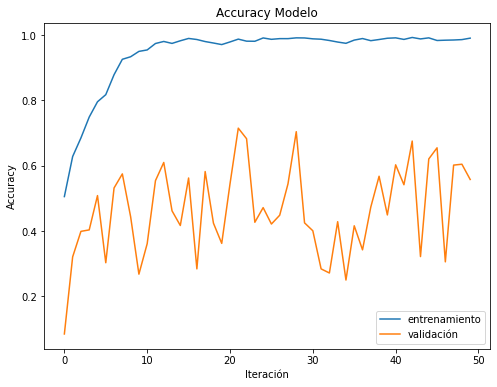

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history_m5['accuracy'])
plt.plot(history_m5['val_accuracy'])
plt.title('Accuracy Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='lower right')
plt.show()

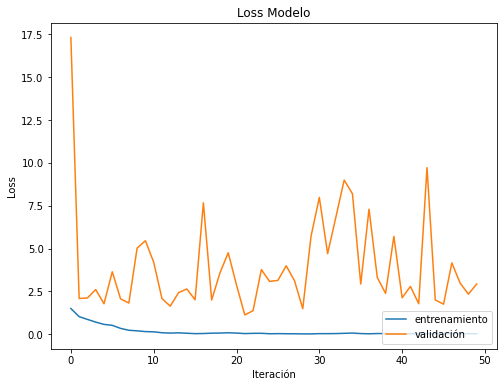

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history_m5['loss'])
plt.plot(history_m5['val_loss'])
plt.title('Loss Modelo')
plt.ylabel('Loss')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='lower right')
plt.show()

In [ ]:
ev_m4 = model_4.evaluate(X_test, y_test, verbose=2)
print(ev_m4)

model_4_cb = tf.keras.models.load_model('./models/model_4.h5')
ev_m4_2 = model_4_cb.evaluate(X_test, y_test, verbose=2)
print(ev_m4_2)

# print(model.predict(test_images).shape)

36/36 - 18s - loss: 1.9354 - accuracy: 0.5605 - mse: 0.0774
[1.9354239702224731, 0.5604982376098633, 0.07736549526453018]
36/36 - 18s - loss: 1.0793 - accuracy: 0.6619 - mse: 0.0539
[1.0792948007583618, 0.6619216799736023, 0.053901005536317825]


In [ ]:
model_5_cb = tf.keras.models.load_model('./models/model_5_sgd.h5')
ev_m5_2 = model_5_cb.evaluate(X_test, y_test, verbose=2)
print(ev_m5_2)

36/36 - 19s - loss: 1.0354 - accuracy: 0.6993
[1.035446047782898, 0.6992882490158081]


In [ ]:
model_5_cb = tf.keras.models.load_model('./models/model_5.h5')
ev_m5_2 = model_5_cb.evaluate(X_test, y_test, verbose=2)
print(ev_m5_2)

36/36 - 19s - loss: 1.2691 - accuracy: 0.6842
[1.2690564393997192, 0.6841636896133423]


In [ ]:
# model_5 = tf.keras.models.load_model('./models/model_5')
# results_train_5 = model_5.evaluate(X, y, verbose=2)
# results_val_5 = model_5.evaluate(X_val, y_val, verbose=2)
# results_test_5 = model_5.evaluate(X_test, y_test, verbose=2)

model_5 = tf.keras.models.load_model('./models/model_5.h5')
# results_train_5_2 = model_5_2.evaluate(X, y, verbose=2)
# results_val_5_2 = model_5_2.evaluate(X_val, y_val, verbose=2)
results_test_5 = model_5.evaluate(X_test, y_test, verbose=2)
results_test_5
# results_train_5,results_val_5,results_test_5, results_train_5_2,results_val_5_2,results_test_5_2

36/36 - 17s - loss: 1.2691 - accuracy: 0.6842


[1.2690564393997192, 0.6841636896133423]

In [ ]:
models_res = []
models_res.append({"Modelo":"19",
                   "data":'original',
                   "type":"full",
                  "Descripción":"Conv Net, with batch normalization",
                  "train_loss":str(results_train_5[0]),
                  "train_acc":str(results_train_5[1]),
                  "val_loss":str(results_val_5[0]),
                  "val_acc":str(results_val_5[1]),
                  "test_loss":str(results_test_5[0]),
                  "test_acc":str(results_test_5[1])
                 })
models_res.append({"Modelo":"19",
                   "data":'original',
                   "type":"callback",
                  "Descripción":"Conv Net, with batch normalization",
                   "train_loss":str(results_train_5_2[0]),
                  "train_acc":str(results_train_5_2[1]),
                  "val_loss":str(results_val_5_2[0]),
                  "val_acc":str(results_val_5_2[1]),
                  "test_loss":str(results_test_5_2[0]),
                  "test_acc":str(results_test_5_2[1])
                 })

### Model 6

In [ ]:
#Creación Modelo
#Design
# Se define como un modelo secuencial
model_6 = Sequential()

# Se añaden las capas y sus hiperparámetros
model_6.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model_6.add(BatchNormalization())

model_6.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model_6.add(BatchNormalization())

# model_6.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model_6.add(BatchNormalization())

# model_6.add(MaxPooling2D(pool_size=(2, 2))) #20x20
# model_6.add(BatchNormalization())

model_6.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_6.add(BatchNormalization())

model_6.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model_6.add(BatchNormalization())

model_6.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_6.add(BatchNormalization())

model_6.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model_6.add(BatchNormalization())

model_6.add(Flatten())
model_6.add(Dense(128, activation='relu'))
model_6.add(BatchNormalization())

model_6.add(Dense(num_classes, activation='softmax'))

model_6.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
callbacks_m6 = [tf.keras.callbacks.TensorBoard("./histories/model_6", histogram_freq=1),
                ModelCheckpoint(filepath="./models/model_6.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_m6 = model_6.fit(X,y,
                   steps_per_epoch = step_size_train,
                   validation_data = (X_val,y_val),
                   validation_steps = step_size_val,
                   epochs=50, callbacks=callbacks_m6)

Epoch 1/50
104/104 [==============================] - 224s 2s/step - loss: 0.0104 - accuracy: 0.9934 - val_loss: 2.0813 - val_accuracy: 0.5786

Epoch 00001: val_loss improved from inf to 2.08130, saving model to ./models/model_6.h5
Epoch 2/50
104/104 [==============================] - 224s 2s/step - loss: 0.0112 - accuracy: 0.9952 - val_loss: 1.9676 - val_accuracy: 0.5894

Epoch 00002: val_loss improved from 2.08130 to 1.96760, saving model to ./models/model_6.h5
Epoch 3/50
104/104 [==============================] - 223s 2s/step - loss: 0.0109 - accuracy: 0.9943 - val_loss: 1.9376 - val_accuracy: 0.6173

Epoch 00003: val_loss improved from 1.96760 to 1.93759, saving model to ./models/model_6.h5
Epoch 4/50
104/104 [==============================] - 225s 2s/step - loss: 0.0104 - accuracy: 0.9949 - val_loss: 2.3899 - val_accuracy: 0.5049

Epoch 00004: val_loss did not improve from 1.93759
Epoch 5/50
104/104 [==============================] - 224s 2s/step - loss: 0.0098 - accuracy: 0.9952 

In [ ]:
with open('./histories/model_6_h', 'wb') as file_pi:
        pickle.dump(history_m6.history, file_pi)
model_6.save('./models/model_6')

INFO:tensorflow:Assets written to: ./models/model_6/assets


In [ ]:
new_model_6 = tf.keras.models.load_model('./models/model_6.h5')

# Show the model architecture
# new_model.summary()

In [ ]:
loss, acc = new_model_6.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# print(model.predict(test_images).shape)

37/37 - 14s - loss: 1.3894 - accuracy: 0.6693
Restored model, accuracy: 66.93%


In [ ]:
# model_6 = tf.keras.models.load_model('./models/model_6')
# results_train_6 = model_6.evaluate(X, y, verbose=2)
# results_val_6 = model_6.evaluate(X_val, y_val, verbose=2)
# results_test_6 = model_6.evaluate(X_test, y_test, verbose=2)

model_6_2 = tf.keras.models.load_model('./models/model_6.h5')
results_train_6_2 = model_6_2.evaluate(X, y, verbose=2)
results_val_6_2 = model_6_2.evaluate(X_val, y_val, verbose=2)
results_test_6_2 = model_6_2.evaluate(X_test, y_test, verbose=2)

# results_train_6,results_val_6,results_test_6, 
results_train_6_2,results_val_6_2,results_test_6_2

105/105 - 48s - loss: 0.0142 - accuracy: 0.9958
35/35 - 16s - loss: 1.7214 - accuracy: 0.6307
36/36 - 16s - loss: 2.0384 - accuracy: 0.5721


([0.014168520458042622, 0.995819628238678],
 [1.7214266061782837, 0.6307277679443359],
 [2.038362741470337, 0.5720640420913696])

In [ ]:
# models_res.append({"Modelo":"20",
#                    "type":"full",
#                   "Descripción":"Conv Net, with batch normalization and less layers",
#                       "train":{
#                           "loss":str(results_train_6[0]),
#                           "acc":str(results_train_6[1])
#                       },
#                       "val":{
#                           "loss":str(results_val_6[0]),
#                           "acc":str(results_val_6[1]),
#                       },
#                       "test":{
#                           "loss":str(results_test_6[0]),
#                           "acc":str(results_test_6[1]),
#                       },
#                  })
models_res.append({"Modelo":"20",
                   "data":'original',
                   "type":"callback",
                  "Descripción":"Conv Net, with batch normalization less layers",
                   "train_loss":str(results_train_6_2[0]),
                  "train_acc":str(results_train_6_2[1]),
                  "val_loss":str(results_val_6_2[0]),
                  "val_acc":str(results_val_6_2[1]),
                  "test_loss":str(results_test_6_2[0]),
                  "test_acc":str(results_test_6_2[1])
                 })
# models_res

### Model 7

In [ ]:
#Creación Modelo
#Design
# Se define como un modelo secuencial
model_7 = Sequential()

# Se añaden las capas y sus hiperparámetros
model_7.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model_7.add(BatchNormalization())

model_7.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model_7.add(BatchNormalization())

model_7.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_7.add(BatchNormalization())

model_7.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model_7.add(BatchNormalization())

model_7.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_7.add(BatchNormalization())

model_7.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model_7.add(BatchNormalization())

model_7.add(Conv2D(32, (10, 10), padding='same', activation='relu',kernel_regularizer=regularizers.l2(l=0.01),use_bias=True))
model_7.add(BatchNormalization())

model_7.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model_7.add(BatchNormalization())

model_7.add(Flatten())
model_7.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(l=0.01)))
model_7.add(BatchNormalization())

model_7.add(Dense(num_classes, activation='softmax'))

model_7.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model_7.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 200, 200, 32)      320       
_________________________________________________________________
batch_normalization_34 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 50, 32)       

In [ ]:
callbacks_m7 = [ModelCheckpoint(filepath="./models/model_7.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_m7 = model_7.fit(X,y,
                   steps_per_epoch = step_size_train,
                   validation_data = (X_val,y_val),
                   validation_steps = step_size_val,
                   epochs=50, callbacks=callbacks_m7)

Epoch 1/50
107/107 [==============================] - 163s 2s/step - loss: 9.9064 - accuracy: 0.4264 - val_loss: 12.2210 - val_accuracy: 0.0844

Epoch 00001: val_loss improved from inf to 12.22103, saving model to ./models/model_7.h5
Epoch 2/50
107/107 [==============================] - 157s 1s/step - loss: 3.6115 - accuracy: 0.5968 - val_loss: 5.0113 - val_accuracy: 0.2846

Epoch 00002: val_loss improved from 12.22103 to 5.01133, saving model to ./models/model_7.h5
Epoch 3/50
107/107 [==============================] - 155s 1s/step - loss: 1.9865 - accuracy: 0.6619 - val_loss: 4.0502 - val_accuracy: 0.3246

Epoch 00003: val_loss improved from 5.01133 to 4.05022, saving model to ./models/model_7.h5
Epoch 4/50
107/107 [==============================] - 157s 1s/step - loss: 1.6678 - accuracy: 0.6895 - val_loss: 5.8039 - val_accuracy: 0.2132

Epoch 00004: val_loss did not improve from 4.05022
Epoch 5/50
107/107 [==============================] - 160s 1s/step - loss: 1.5478 - accuracy: 0.68

In [ ]:
with open('./histories/model_7', 'wb') as file_pi:
        pickle.dump(history_m7.history, file_pi)
model_5.save('./models/model_7')

INFO:tensorflow:Assets written to: ./models/model_7/assets


In [ ]:
new_model_7 = tf.keras.models.load_model('./models/model_7.h5')

# Show the model architecture
# new_model.summary()

In [ ]:
loss, acc = new_model_7.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# print(model.predict(test_images).shape)

37/37 - 11s - loss: 1.2778 - accuracy: 0.6995
Restored model, accuracy: 69.95%


In [ ]:
# model_7 = tf.keras.models.load_model('./models/model_7')
# results_train_7 = model_7.evaluate(X, y, verbose=2)
# results_val_7 = model_7.evaluate(X_val, y_val, verbose=2)
# results_test_7 = model_7.evaluate(X_test, y_test, verbose=2)

# model_7_2 = tf.keras.models.load_model('./models/model_7.h5')
# results_train_7_2 = model_7_2.evaluate(X, y, verbose=2)
# results_val_7_2 = model_7_2.evaluate(X_val, y_val, verbose=2)
# results_test_7_2 = model_7_2.evaluate(X_test, y_test, verbose=2)

# results_train_7,results_val_7,results_test_7, results_train_7_2,results_val_7_2,results_test_7_2

models_res.append({"Modelo":"21",
                   "type":"full",
                  "Descripción":"Conv Net, with batch normalization and regularization",
                      "train":{
                          "loss":str(results_train_7[0]),
                          "acc":str(results_train_7[1])
                      },
                      "val":{
                          "loss":str(results_val_7[0]),
                          "acc":str(results_val_7[1]),
                      },
                      "test":{
                          "loss":str(results_test_7[0]),
                          "acc":str(results_test_7[1]),
                      },

                 })
models_res.append({"Modelo":"21",
                   "type":"callback",
                  "Descripción":"Conv Net, with batch normalization and regularization",
                      "train":{
                          "loss":str(results_train_7_2[0]),
                          "acc":str(results_train_7_2[1]),

                      },
                      "val":{
                          "loss":str(results_val_7_2[0]),
                          "acc":str(results_val_7_2[1]),
                      },
                      "test":{
                          "loss":str(results_test_7_2[0]),
                          "acc":str(results_test_7_2[1]),
                      },

                 })
models_res

[{'Descripción': 'Conv Net',
  'Modelo': '15',
  'test': {'acc': '0.5345423221588135', 'loss': '4.601230144500732'},
  'train': {'acc': '1.0', 'loss': '0.0016702943248674273'},
  'type': 'full',
  'val': {'acc': '0.5491731762886047', 'loss': '4.390067100524902'}},
 {'Descripción': 'Conv Net',
  'Modelo': '15',
  'test': {'acc': '0.5146805047988892', 'loss': '1.2924777269363403'},
  'train': {'acc': '0.5944927334785461', 'loss': '1.066419005393982'},
  'type': 'callback',
  'val': {'acc': '0.5117493271827698', 'loss': '1.2711520195007324'}},
 {'Descripción': 'Conv Net, with drop out',
  'Modelo': '17',
  'test': {'acc': '0.1165803074836731', 'loss': '2.6401329040527344'},
  'train': {'acc': '0.11652173846960068', 'loss': '2.6299238204956055'},
  'type': 'full',
  'val': {'acc': '0.11662314832210541', 'loss': '2.6229522228240967'}},
 {'Descripción': 'Conv Net, with drop ou',
  'Modelo': '17',
  'test': {'acc': '0.1165803074836731', 'loss': '2.4819772243499756'},
  'train': {'acc': '0.116

In [ ]:
with open('./models/results_1.json', 'w') as fout:
    json.dump(models_res , fout)

### Model 8

# New Section

In [ ]:
#Creación Modelo
#Design
# Se define como un modelo secuencial
model_8 = Sequential()

# Se añaden las capas y sus hiperparámetros
model_8.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model_8.add(BatchNormalization())

model_8.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model_8.add(BatchNormalization())

model_8.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model_8.add(BatchNormalization())

model_8.add(Flatten())
model_8.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model_8.add(BatchNormalization())

model_8.add(Dense(num_classes, activation='softmax'))

model_8.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
callbacks_m8 = [tf.keras.callbacks.TensorBoard("./histories/model_8", histogram_freq=1),
                ModelCheckpoint(filepath="./models/model_8.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_m8 = model_8.fit(X,y,
                   steps_per_epoch = step_size_train,
                   validation_data = (X_val,y_val),
                   validation_steps = step_size_val,
                   epochs=50, callbacks=callbacks_m8)

Epoch 1/50
104/104 [==============================] - 208s 2s/step - loss: 3.1741 - accuracy: 0.4122 - val_loss: 4.1206 - val_accuracy: 0.0961

Epoch 00001: val_loss improved from inf to 4.12059, saving model to ./models/model_8.h5
Epoch 2/50
104/104 [==============================] - 208s 2s/step - loss: 1.7541 - accuracy: 0.6234 - val_loss: 3.1855 - val_accuracy: 0.2049

Epoch 00002: val_loss improved from 4.12059 to 3.18553, saving model to ./models/model_8.h5
Epoch 3/50
104/104 [==============================] - 207s 2s/step - loss: 1.5313 - accuracy: 0.6823 - val_loss: 4.5417 - val_accuracy: 0.1222

Epoch 00003: val_loss did not improve from 3.18553
Epoch 4/50
104/104 [==============================] - 206s 2s/step - loss: 1.5047 - accuracy: 0.7069 - val_loss: 3.9578 - val_accuracy: 0.1779

Epoch 00004: val_loss did not improve from 3.18553
Epoch 5/50
104/104 [==============================] - 206s 2s/step - loss: 1.5340 - accuracy: 0.7254 - val_loss: 5.8674 - val_accuracy: 0.1896

In [ ]:
model_8_2 = tf.keras.models.load_model('./models/model_8.h5')
results_train_8_2 = model_8_2.evaluate(X, y, verbose=2)
results_val_8_2 = model_8_2.evaluate(X_val, y_val, verbose=2)
results_test_8_2 = model_8_2.evaluate(X_test, y_test, verbose=2)

# results_train_6,results_val_6,results_test_6, 
results_train_8_2,results_val_8_2,results_test_8_2

105/105 - 48s - loss: 1.0742 - accuracy: 0.9003
35/35 - 16s - loss: 2.1193 - accuracy: 0.6119
36/36 - 16s - loss: 2.3064 - accuracy: 0.5623


([1.074174404144287, 0.9002687335014343],
 [2.1193435192108154, 0.6118598580360413],
 [2.3064122200012207, 0.5622775554656982])

In [ ]:
models_res.append({"Modelo":"24",
                   "data":'original',
                   "type":"callback",
                  "Descripción":"Conv Net, with batch normalization and regularizer",
                   "train_loss":str(results_train_8_2[0]),
                  "train_acc":str(results_train_8_2[1]),
                  "val_loss":str(results_val_8_2[0]),
                  "val_acc":str(results_val_8_2[1]),
                  "test_loss":str(results_test_8_2[0]),
                  "test_acc":str(results_test_8_2[1])
                 })

In [ ]:
import pandas as pd

In [ ]:
with open('./resultados/results_org.json', 'w') as fout:
    json.dump(models_res , fout)

In [ ]:
pd.DataFrame(models_res).sort_values('test_acc',ascending=False)#.iloc[0,:]#.to_latex(index=True)

Modelo      data  ...           test_loss            test_acc
1     19  original  ...  1.2690564393997192  0.6841636896133423
2     20  original  ...   2.038362741470337  0.5720640420913696
3     24  original  ...  2.3064122200012207  0.5622775554656982
0     19  original  ...  1.9354239702224731  0.5604982376098633

[4 rows x 10 columns]

## eval

In [ ]:
Y_pred = model_5.predict(X_test,steps=step_size_test)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
y_pred

array([4, 4, 7, ..., 8, 8, 8])

In [ ]:
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
accuracy = accuracy_score(y_test_, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.684164


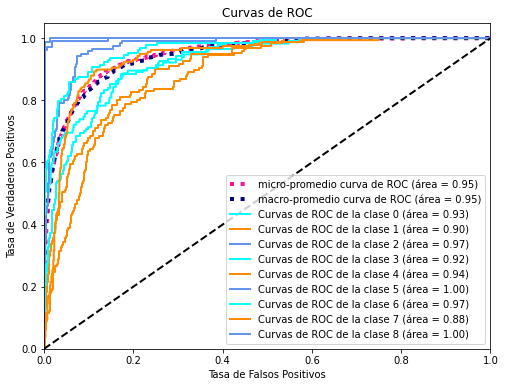

In [ ]:
y_pred_prob =  Y_pred
y_pred_classes = y_pred
test_labels_one_hot = to_categorical(y_test_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_one_hot.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.figure(1)
plt.plot((fpr["micro"]), (tpr["micro"]),
         label='micro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curvas de ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas de ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_test_, y_pred))
print('Classification Report')
target_names = ['11', '21','22','23','24','31','32','33','52']
print(classification_report(y_test_, y_pred, target_names=target_names))

Confusion Matrix
[[ 73   1   0   3  22   2   1  13   0]
 [  9  65  17   6   0   1  12  11   0]
 [  0  13  96   2   0   6   2   1   0]
 [  2  21  25  65   1   1  13   9   0]
 [ 17   4   0   3 106   0   7  21   0]
 [  0   0   1   0   0 106   0   0   0]
 [  0   3   2   1   0   9 111   2   0]
 [  2   8   5  10  24   5  33  58   1]
 [  0   3   0   0   0   0   0   0  89]]
Classification Report
              precision    recall  f1-score   support

          11       0.71      0.63      0.67       115
          21       0.55      0.54      0.54       121
          22       0.66      0.80      0.72       120
          23       0.72      0.47      0.57       137
          24       0.69      0.67      0.68       158
          31       0.82      0.99      0.89       107
          32       0.62      0.87      0.72       128
          33       0.50      0.40      0.44       146
          52       0.99      0.97      0.98        92

    accuracy                           0.68      1124
   macro avg 

In [ ]:
def generate_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusion', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm,2)
        print('Matriz de Confusion Normalizada')
    else:
        print('Matriz de Confusion No Normalizada')
      # print (cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white'
        if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('Valid data')
    plt.xlabel('Predicted data')

Matriz de Confusion No Normalizada


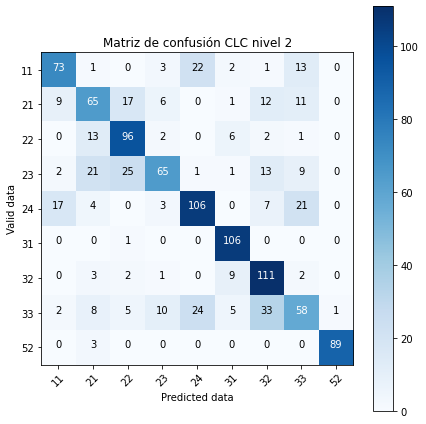

In [ ]:
cm = confusion_matrix(y_test_, y_pred)

cm_plot_labels = ['11', '21','22','23','24','31','32','33','52']
generate_confusion_matrix(cm, cm_plot_labels, title = 'Matriz de confusión CLC nivel 2')

In [ ]:
level_1 = {0:0,1:1,2:1,3:1,4:1,5:2,6:2,7:2,8:3}
y_test_lev1 = [level_1[i] for i in y_test_]  
y_pred_lev1 = [level_1[i] for i in y_pred] 


In [ ]:
cm_lev1 = confusion_matrix(y_test_lev1, y_pred_lev1)

cm_plot_labels_lev1 = ['1', '2','3','5']
generate_confusion_matrix(cm_lev1, cm_plot_labels_lev1, title = 'Matriz de confusión CLC nivel 1, normalizada',normalize=True)

Matriz de Confusion Normalizada


In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_, y_pred)
accuracy_lev1 = accuracy_score(y_test_lev1, y_pred_lev1)
print('Accuracy model at level 1 : {} and at level 2 : {}'.format(accuracy_lev1,accuracy))

Accuracy model at level 1 : 0.8096085409252669 and at level 2 : 0.6841637010676157


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_test_, y_pred, average = 'macro')
precision_lev1 = precision_score(y_test_lev1, y_pred_lev1, average = 'macro')
print('precision at level 1 : {} and at level 2 : {}'.format(precision_lev1, precision ))

precision at level 1 : 0.8245174023944438 and at level 2 : 0.6956539233580811


In [ ]:
# recall: tp / (tp + fn)
recall = recall_score(y_test_, y_pred, average = 'macro')
recall_lev1 = recall_score(y_test_lev1, y_pred_lev1, average = 'macro')
print('recall at level 1 : {} and at level 2 : {}'.format( recall_lev1,recall))

recall at level 1 : 0.8109030974875707 and at level 2 : 0.7044227339957865


In [ ]:
# f1: 2 tp / (2 tp + fp + fn)

f1 = f1_score(y_test_, y_pred, average = 'macro')
f1_lev1 = f1_score(y_test_lev1, y_pred_lev1, average = 'macro')
print('f1 at level 1 : {} and at level 2 : {}'.format(f1_lev1, f1 ))

f1 at level 1 : 0.8164387506117909 and at level 2 : 0.6922144236595899


In [ ]:
# kappa
kappa = cohen_kappa_score(y_test_, y_pred)
kappa_lev1 = cohen_kappa_score(y_test_lev1, y_pred_lev1)
print('kappa at level 1 : {} and at level 2 : {}'.format(kappa_lev1, kappa ))

kappa at level 1 : 0.7030254767240155 and at level 2 : 0.644156930521333


In [ ]:
import pandas as pd
metricas_df = pd.DataFrame({'Métrica':['Accuracy','Precision','Recall','f1','kappa'],
              'Nivel 1':[accuracy_lev1,precision_lev1,recall_lev1,f1_lev1,kappa_lev1],
              'Nivel 2':[accuracy,precision,recall,f1,kappa]})
metricas_df.to_latex(index=False)


'\\begin{tabular}{lrr}\n\\toprule\n   Métrica &   Nivel 1 &   Nivel 2 \\\\\n\\midrule\n  Accuracy &  0.809609 &  0.684164 \\\\\n Precision &  0.824517 &  0.695654 \\\\\n    Recall &  0.810903 &  0.704423 \\\\\n        f1 &  0.816439 &  0.692214 \\\\\n     kappa &  0.703025 &  0.644157 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
rn50_Arch_2 = ResNet50(weights=None,input_shape=(200,200,1),include_top=False,classes=num_classes)
# rn50_Arch.trainable = False

model_rn50_da_bn = Sequential()

model_rn50_da_bn.add(rn50_Arch_2)

model_rn50_da_bn.add(Flatten())


model_rn50_da_bn.add(Dense(512, activation="relu"))
model_rn50_da_bn.add(BatchNormalization())
model_rn50_da_bn.add(Dense(num_classes, activation="softmax"))
model_rn50_da_bn.compile(loss='categorical_crossentropy'
                  , optimizer='sgd', metrics=['acc', 'mse'])  

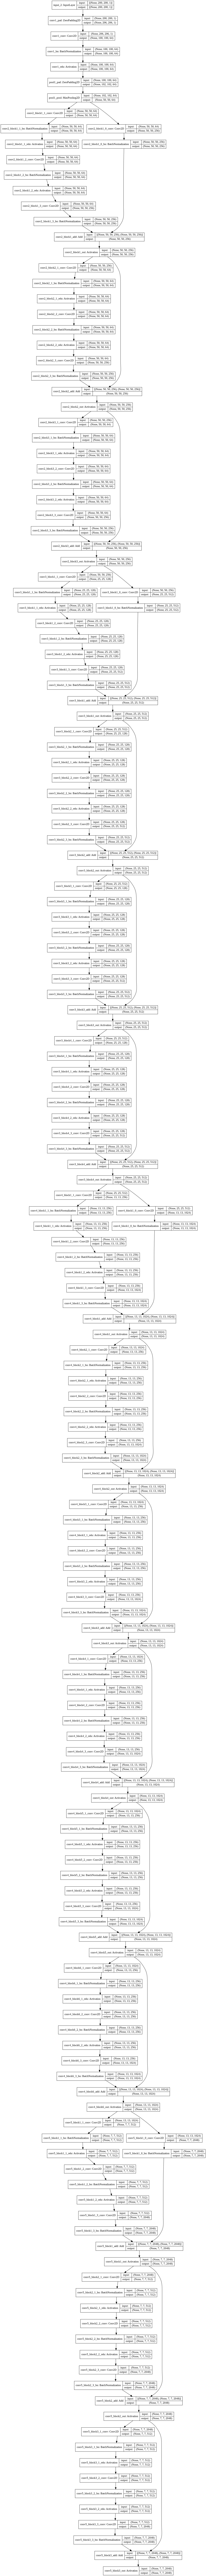

In [ ]:
dot_img_file = './models/model_rn50_1.png'
tf.keras.utils.plot_model(rn50_Arch_2, to_file=dot_img_file, show_shapes=True)